In [179]:
import os
import json
import glob
import csv
import math
import pandas as pd
from io import StringIO
from pathlib import Path
from scipy.stats import spearmanr
import seaborn as sns

In [108]:
jars = glob.glob("../versions/*/*.jar")
libs = glob.glob("../versions/*/lib")
versions =  glob.glob("../versions/*")
versions.sort()
versions_f = [v.split("\\")[-1] for v in versions]

In [109]:
layer_ex = dict()
ckjm_ex = dict()
for j, l, v, vf in zip(jars, libs, versions, versions_f): 
    process = os.popen(f"java -jar {Path('../layer_extractor.jar')} {j}")
    # layer_ex[vf] = process.read()
    layers = pd.read_csv(StringIO(process.read()))
    process.close()
    if("5.5.13.3" in j):
        # read csv
        ckjm_vals = pd.read_csv(Path("../versions/5.5.13.3/ck-metrics-5.5.13.3.csv"))
    else:
        process = os.popen(f"java -jar {Path('../ckjm_adapted.jar')} {j} {l}")
        ckjm_vals = pd.read_csv(StringIO(process.read()))
    
    ckjm_ex[vf] = ckjm_vals.merge(layers, on='ClassName')
    process.close()

In [118]:
num_classes = [len(a) for a in ckjm_ex.values()]
num_classes

<generator object <genexpr> at 0x7f6711f7da20>


In [111]:
def fwbr_n(CBO, DIT, WMC, RFC, LCOM):
 return -(9.023 * math.log(CBO + 1) + \
 3.945 * math.log(DIT + 1) - \
 0.678 * math.log(WMC + 1) - \
 0.826 * math.log(RFC + 1) - \
 0.378 * math.log(LCOM + 1))

In [112]:
cols = ['ClassName', 'WMC', 'DIT', 'NOC', 'CBO', 'RFC', 'LCOM', 'CA', 'NPM', 'Layer']
ckjm_dict = {k.split('/')[-1]:v for k, v in ckjm_ex.items()}

In [126]:
# print(ckjm_dict)
for x in ckjm_dict.keys():
    print(f"{x}, {len(ckjm_dict[x])}")

5.0.6, 566
5.1.3, 587
5.2.1, 678
5.3.4, 638
5.4.5, 933
5.5.13.3, 827


In [114]:
for version in ckjm_dict:
    print(f"versie {version}")
    for metric in ckjm_dict[version].drop('ClassName', axis=1):
        # print(metric)
        print(f"{ckjm_dict[version][metric].astype('float64').min()} - {ckjm_dict[version][metric].astype('float64').max()}")
        # print(version, metric)

versie 5.0.6
0.0 - 176.0
1.0 - 6.0
0.0 - 42.0
0.0 - 86.0
0.0 - 436.0
0.0 - 9082.0
0.0 - 151.0
0.0 - 158.0
0.0 - 13.0
versie 5.1.3
0.0 - 176.0
1.0 - 6.0
0.0 - 31.0
0.0 - 86.0
0.0 - 438.0
0.0 - 9533.0
0.0 - 150.0
0.0 - 158.0
0.0 - 12.0
versie 5.2.1
0.0 - 195.0
1.0 - 6.0
0.0 - 32.0
0.0 - 89.0
0.0 - 455.0
0.0 - 11261.0
0.0 - 160.0
0.0 - 164.0
0.0 - 12.0
versie 5.3.4
0.0 - 181.0
1.0 - 6.0
0.0 - 31.0
0.0 - 86.0
0.0 - 438.0
0.0 - 9533.0
0.0 - 157.0
0.0 - 163.0
0.0 - 12.0
versie 5.4.5
0.0 - 249.0
1.0 - 6.0
0.0 - 34.0
0.0 - 102.0
0.0 - 561.0
0.0 - 17152.0
0.0 - 188.0
0.0 - 211.0
0.0 - 18.0
versie 5.5.13.3
0.0 - 208.0
1.0 - 6.0
0.0 - 34.0
0.0 - 94.0
0.0 - 499.0
0.0 - 12393.0
0.0 - 182.0
0.0 - 170.0
0.0 - 17.0


In [127]:
def fwbr_n(CBO, DIT, WMC, RFC, LCOM):
 return -(9.023 * math.log(CBO + 1) + \
 3.945 * math.log(DIT + 1) - \
 0.678 * math.log(WMC + 1) - \
 0.826 * math.log(RFC + 1) - \
 0.378 * math.log(LCOM + 1))

def apply_fwbr_n(row):
    return fwbr_n(row['CBO'], row['DIT'], row['WMC'], row['RFC'], row['LCOM'])

def fwbr(CBO, DIT, WMC, RFC, LCOM, NOC):
 return -(8.753 * math.log(CBO + 1) + \
 2.505 * math.log(DIT + 1) - \
 1.922* math.log(WMC + 1) - \
 0.892 * math.log(RFC + 1) - \
 0.399 * math.log(LCOM + 1) - \
 1.080 * math.log(NOC + 1))

def apply_fwbr(row):
    return fwbr(row['CBO'], row['DIT'], row['WMC'], row['RFC'], row['LCOM'], row['NOC'])


for version in ckjm_dict:
    for metric in ['WMC', 'DIT', 'NOC', 'CBO', 'RFC', 'LCOM', 'CA', 'NPM']:
        ckjm_dict[version][metric] = pd.to_numeric(ckjm_dict[version][metric])
    ckjm_dict[version]['fwbr_n'] = ckjm_dict[version].apply(lambda row: apply_fwbr_n(row), axis=1)
    ckjm_dict[version]['fwbr'] = ckjm_dict[version].apply(lambda row: apply_fwbr(row), axis=1)



In [151]:
for x in ckjm_dict.keys():
    print(x)
    print(ckjm_dict[x][['fwbr', 'fwbr_n']].describe())
    

5.0.6
             fwbr      fwbr_n
count  566.000000  566.000000
mean    -8.294404  -12.815970
std      6.775526    7.546961
min    -24.003512  -32.788817
25%    -13.682906  -18.262294
50%     -8.429503  -13.113511
75%     -3.447274   -7.611325
max      7.567341    2.876432
5.1.3
             fwbr      fwbr_n
count  587.000000  587.000000
mean    -8.173623  -12.635670
std      6.814923    7.581979
min    -24.003512  -32.747512
25%    -13.573729  -18.052383
50%     -8.259729  -12.870994
75%     -3.228774   -7.283921
max      7.567341    2.876432
5.2.1
             fwbr      fwbr_n
count  678.000000  678.000000
mean    -7.959590  -12.419324
std      6.842015    7.587099
min    -24.172348  -32.915462
25%    -13.342388  -17.708785
50%     -7.984426  -12.658591
75%     -3.228774   -7.171107
max      7.567341    2.888269
5.3.4
             fwbr      fwbr_n
count  638.000000  638.000000
mean    -8.034669  -12.545637
std      6.799050    7.527440
min    -24.003512  -32.747512
25%    -13.48277

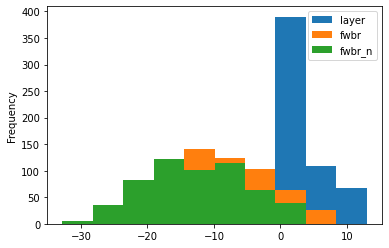

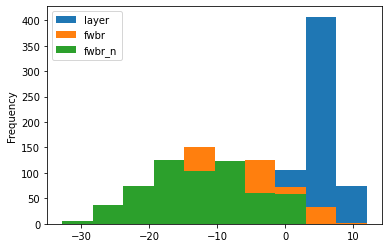

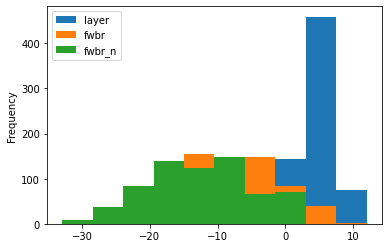

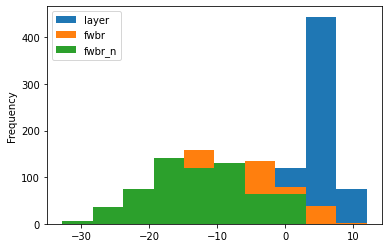

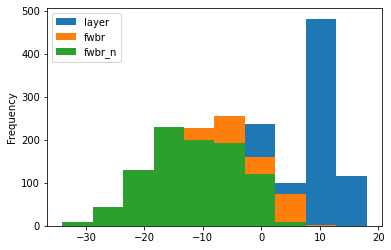

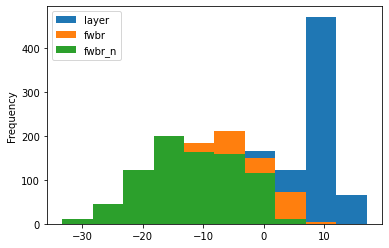

In [176]:
for x in ckjm_dict:
   ckjm_dict[x]
   ckjm_dict[x][['layer', 'fwbr', 'fwbr_n']].plot(kind='hist')
    

In [188]:
# question 4, spearman
print('version, rho, p')
for x in ckjm_dict:
    rho, p = spearmanr(ckjm_dict[x]['layer'], ckjm_dict[x]['fwbr'])
    print(f"{x}, {rho}, {p}")

version, rho, p
5.0.6, -0.4340689492087184, 2.0766686364108052e-27
5.1.3, -0.42371822177378177, 5.623657431097273e-27
5.2.1, -0.47454108374820425, 2.2723902143425045e-39
5.3.4, -0.4484093704117223, 6.971263385015753e-33
5.4.5, -0.547426411536562, 4.620876328706001e-74
5.5.13.3, -0.5725280889098705, 3.3957603624454266e-73


<AxesSubplot:>

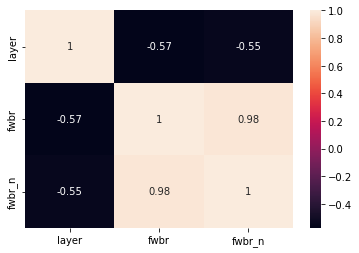

In [185]:

corr = ckjm_dict[x][['layer', 'fwbr', 'fwbr_n']].corr(method = 'spearman')

sns.heatmap(corr, annot = True)